<a href="https://colab.research.google.com/github/Dennieeeee/Viacom-Custom-Audience-Ads-Analysis/blob/main/Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import sklearn as sk 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
# model development
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# model evaluation
from sklearn import metrics


# Custom_audience_ads.csv
## Data Cleaning and Trim Outliers

In [2]:
custom = pd.read_csv('custom_audience_ads.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
custom.head(1)

,account_id,approximate_count,custom_audience_id,name,retention_days,time_created,customer_file_source,description,is_value_based,data_source_type,data_source_sub_type,data_source_creation_params,ad_id,clicks,cpc,impressions,cpm,ctr,comments,video_views,post_reactions
0,104657973074389,1000,6084391234802,Thermador: Retargeting Users who watched Amand...,365,2017-12-08 19:29:08,NOT_APPLICABLE,NaN,False,EVENT_BASED,ENGAGEMENT_EVENTS,"{""prefill"":""true""}",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
custom['time_created'] = pd.to_datetime(custom['time_created'])

In [5]:
custom['month'] = custom['time_created'].dt.month
custom['year'] = custom['time_created'].dt.year
custom['day'] = custom['time_created'].dt.day

In [6]:
custom = custom.drop(columns =['description'])
custom = custom.drop(columns =['comments'])

In [7]:
custom_clean = custom.dropna() #remove missing value and empty columns

In [8]:
#Trim outliers:
starting_percentile = custom_clean['clicks'].quantile(.02)
ending_percentile = custom_clean['clicks'].quantile(.98)
price_outliers_df = custom_clean.loc[((custom_clean['clicks'] <= starting_percentile) | (custom_clean['clicks'] >= ending_percentile))]
custom_clean = custom_clean.loc[((custom_clean['clicks'] > starting_percentile) & (custom_clean['clicks'] < ending_percentile))]

In [9]:
print('Shape of the original dataset: ',custom.shape)
print('Shape of the cleaned dataset: ', custom_clean.shape)

Shape of the original dataset:  (455542, 22)
Shape of the cleaned dataset:  (381161, 22)


# Model Development - Correlation

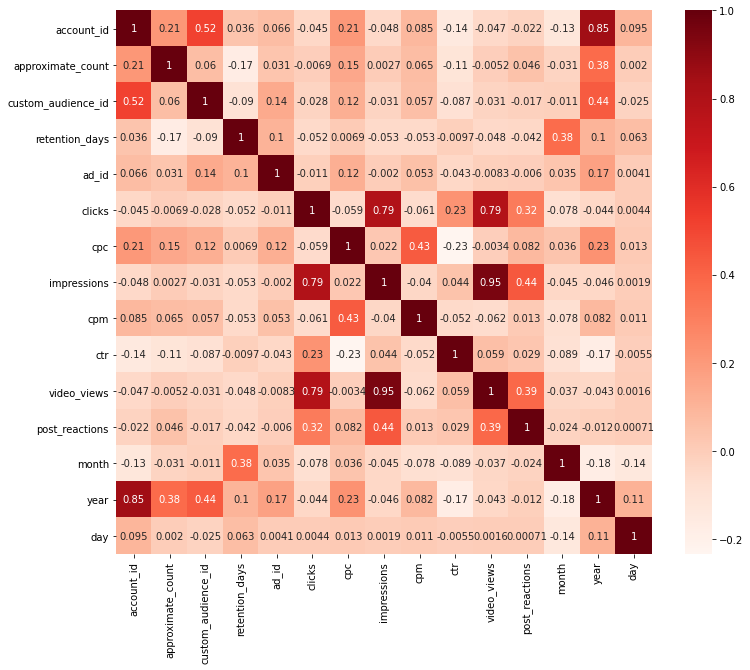

In [10]:
#Generating correlation heatmap
plt.figure(figsize=(12,10))
cor = custom.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [11]:
# find out all features result in large impreesion(correlation > 0.5) and low cpm(correlation <0)
relevant_featuresP1 = cor[(cor["cpm"]<0) & (cor['impressions'] > 0.5) & (cor['impressions'] < 1)]
relevant_featuresP1


,account_id,approximate_count,custom_audience_id,retention_days,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
clicks,-0.044963,-0.006852,-0.028036,-0.051978,-0.010547,1.000000,-0.059500,0.792802,-0.060712,0.227357,0.787036,0.318694,-0.077966,-0.044119,0.004435
video_views,-0.046699,-0.005171,-0.031178,-0.048178,-0.008258,0.787036,-0.003401,0.951364,-0.061597,0.058639,1.000000,0.392339,-0.036701,-0.043075,0.001553


In [12]:
#result table for P1
p1 = print(relevant_featuresP1[["impressions",'cpm']])

             impressions       cpm
clicks          0.792802 -0.060712
video_views     0.951364 -0.061597


P2.What are the attributes of custom audience that result in high engagement?

In [13]:
# find out all features result in large clicks(correlation > 0.5) and low cpc(correlation <0)
relevant_featuresP2 = cor[(cor["cpc"]<0) & (cor['clicks'] > 0) & (cor['clicks'] < 1)]
relevant_featuresP2


,account_id,approximate_count,custom_audience_id,retention_days,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
ctr,-0.144507,-0.113253,-0.086922,-0.009681,-0.042897,0.227357,-0.234236,0.043750,-0.051969,1.000000,0.058639,0.029399,-0.089080,-0.173775,-0.005498
video_views,-0.046699,-0.005171,-0.031178,-0.048178,-0.008258,0.787036,-0.003401,0.951364,-0.061597,0.058639,1.000000,0.392339,-0.036701,-0.043075,0.001553


In [14]:
#result table for P2
p2 = print(relevant_featuresP2[["clicks",'cpc']])

               clicks       cpc
ctr          0.227357 -0.234236
video_views  0.787036 -0.003401


## Model Development - Linear Regression

In [15]:
X = custom_clean[['approximate_count', 'retention_days','cpc', 'impressions',
                  'cpm', 'ctr', 'video_views', 'post_reactions','month','day','year']]
y = custom_clean['clicks']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [17]:
lm = LinearRegression()

In [18]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Model Evaluation - Linear Regression

In [19]:
# print the intercept
print(lm.intercept_)

-29870.47214519029


In [20]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
approximate_count,-0.000002
retention_days,0.597754
cpc,-219.893273
impressions,0.024452
cpm,-21.204900
ctr,19078.498588
video_views,0.004117
post_reactions,-0.163294
month,-63.991969
day,-1.642264


In [21]:
predictions = lm.predict(X_test)

In [22]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 664.5045378368266
MSE: 1631269.1323553734
RMSE: 1277.2114673598
